# Table of Contents
1. [Import Libraries](#1-import-libraries)
2. [Load Dataset](#2-load-dataset)
3. [Data Overview](#3-data-overview)
4. [Data Cleaning & Preprocessing](#4-data-cleaning--preprocessing)
5. [Exploratory Data Analysis](#5-exploratory-data-analysis)
   - 5.1 Time Series Plot
   - 5.2 Distribution Analysis
   - 5.3 Hourly Pattern
   - 5.4 Daily Pattern
   - 5.5 Monthly Pattern
   - 5.6 Yearly Trend
   - 5.7 Correlation Heatmap
6. [Feature Engineering](#6-feature-engineering)
7. [Model Training](#7-model-training)
8. [Model Evaluation](#8-model-evaluation)
9. [Feature Importance](#9-feature-importance)
10. [Predictions vs Actual](#10-predictions-vs-actual)
11. [Save Model](#11-save-model)
12. [Key Insights & Conclusions](#12-key-insights--conclusions)

## 1. Import Libraries

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import warnings

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

# Plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 5)
plt.rcParams['font.size'] = 12

print(' All libraries imported successfully')

 All libraries imported successfully


## 2. Load Dataset

In [13]:
df = pd.read_csv('../data/energy_data.csv')
print('Shape:', df.shape)
df.head(10)

Shape: (52966, 3)


,Start time UTC,End time UTC,Electricity consumption (MWh)
0,31-12-2015 21:00,31-12-2015 22:00,10800
1,31-12-2015 22:00,31-12-2015 23:00,10431
2,31-12-2015 23:00,01-01-2016 00:00,10005
3,01-01-2016 00:00,01-01-2016 01:00,9722
4,01-01-2016 01:00,01-01-2016 02:00,9599
5,01-01-2016 02:00,01-01-2016 03:00,9524
6,01-01-2016 03:00,01-01-2016 04:00,9601
7,01-01-2016 04:00,01-01-2016 05:00,9793
8,01-01-2016 05:00,01-01-2016 06:00,9815
9,01-01-2016 06:00,01-01-2016 07:00,9998


## 3. Data Overview

In [14]:
print('=== Dataset Info ===')
df.info()
print('\n=== Data Types ===')
print(df.dtypes)

=== Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52966 entries, 0 to 52965
Data columns (total 3 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Start time UTC                 52966 non-null  object
 1   End time UTC                   52966 non-null  object
 2   Electricity consumption (MWh)  52966 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.2+ MB

=== Data Types ===
Start time UTC                   object
End time UTC                     object
Electricity consumption (MWh)     int64
dtype: object


In [15]:
print('=== Basic Statistics ===')
df.describe()

=== Basic Statistics ===


,Electricity consumption (MWh)
count,52966.000000
mean,9488.750519
std,1576.241673
min,5341.000000
25%,8322.000000
50%,9277.000000
75%,10602.000000
max,15105.000000


In [16]:
print('=== Missing Values ===')
print(df.isnull().sum())
print('\n=== Duplicate Rows ===')
print(f'Duplicates: {df.duplicated().sum()}')

=== Missing Values ===
Start time UTC                   0
End time UTC                     0
Electricity consumption (MWh)    0
dtype: int64

=== Duplicate Rows ===
Duplicates: 0


## 4. Data Cleaning & Preprocessing

> The dataset is already clean - no missing values or duplicates found.
> We only need to parse dates and extract time-based features.

In [17]:
# Parse datetime columns
df['Start time UTC'] = pd.to_datetime(df['Start time UTC'], format='%d-%m-%Y %H:%M')
df['End time UTC']   = pd.to_datetime(df['End time UTC'],   format='%d-%m-%Y %H:%M')

# Rename target column
df.rename(columns={'Electricity consumption (MWh)': 'consumption'}, inplace=True)

# Sort chronologically
df = df.sort_values('Start time UTC').reset_index(drop=True)

# Extract time features
df['year']      = df['Start time UTC'].dt.year
df['month']     = df['Start time UTC'].dt.month
df['day']       = df['Start time UTC'].dt.day
df['hour']      = df['Start time UTC'].dt.hour
df['dayofweek'] = df['Start time UTC'].dt.dayofweek
df['quarter']   = df['Start time UTC'].dt.quarter
df['dayofyear'] = df['Start time UTC'].dt.dayofyear
df['is_weekend']= df['dayofweek'].isin([5, 6]).astype(int)

print(f'Date range : {df["Start time UTC"].min().date()} → {df["Start time UTC"].max().date()}')
print(f'Total rows : {len(df):,}')
print(f'Columns    : {df.columns.tolist()}')
df.head()

Date range : 2015-12-31 → 2021-12-31
Total rows : 52,966
Columns    : ['Start time UTC', 'End time UTC', 'consumption', 'year', 'month', 'day', 'hour', 'dayofweek', 'quarter', 'dayofyear', 'is_weekend']


,Start time UTC,End time UTC,consumption,year,month,day,hour,dayofweek,quarter,dayofyear,is_weekend
0,2015-12-31 21:00:00,2015-12-31 22:00:00,10800,2015,12,31,21,3,4,365,0
1,2015-12-31 22:00:00,2015-12-31 23:00:00,10431,2015,12,31,22,3,4,365,0
2,2015-12-31 23:00:00,2016-01-01 00:00:00,10005,2015,12,31,23,3,4,365,0
3,2016-01-01 00:00:00,2016-01-01 01:00:00,9722,2016,1,1,0,4,1,1,0
4,2016-01-01 01:00:00,2016-01-01 02:00:00,9599,2016,1,1,1,4,1,1,0


## 5. Exploratory Data Analysis

### 5.1 Full Time Series

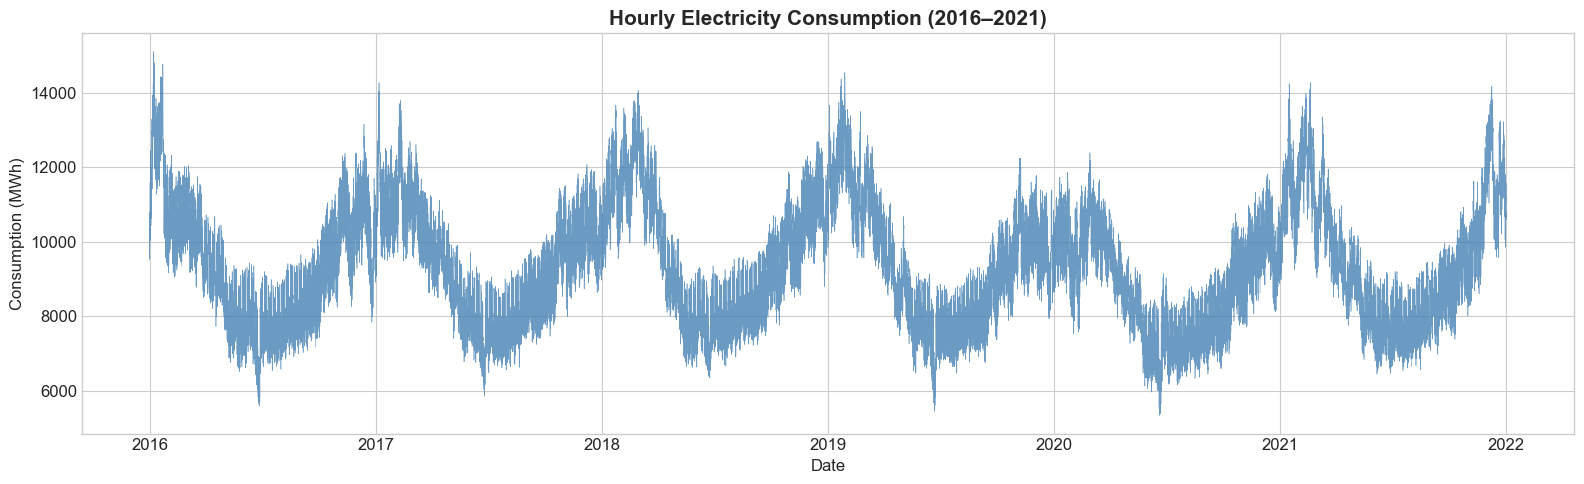

In [18]:
fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(df['Start time UTC'], df['consumption'], linewidth=0.4, alpha=0.8, color='steelblue')
ax.set_title('Hourly Electricity Consumption (2016–2021)', fontsize=15, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Consumption (MWh)')
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.tight_layout()
plt.show()

### 5.2 Distribution of Consumption

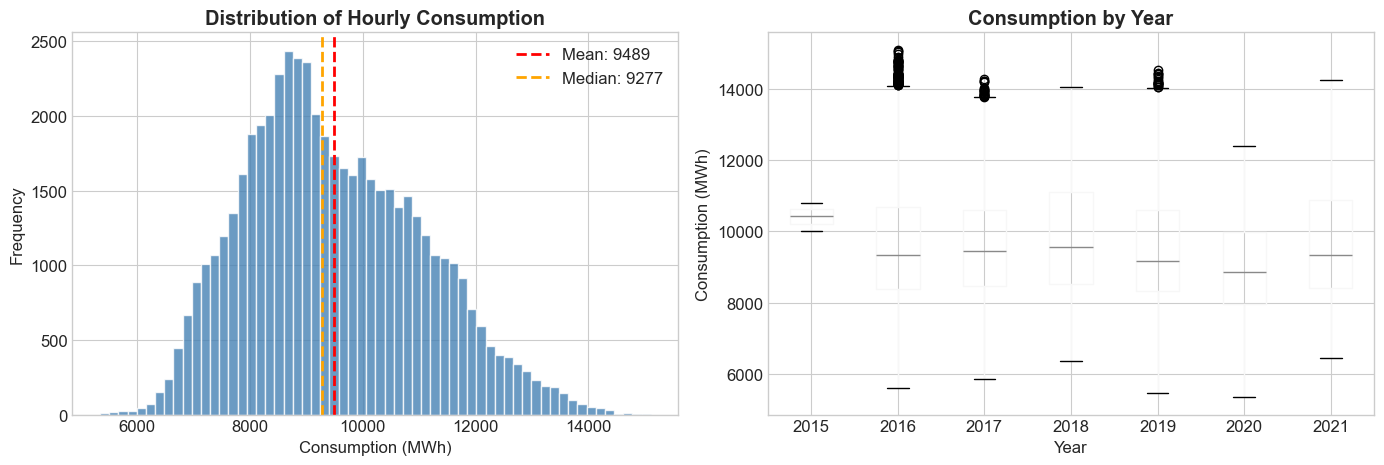

Mean   : 9488.75 MWh
Median : 9277.00 MWh
Std    : 1576.24 MWh
Min    : 5,341 MWh
Max    : 15,105 MWh


In [19]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df['consumption'], bins=60, color='steelblue', edgecolor='white', alpha=0.8)
axes[0].axvline(df['consumption'].mean(),   color='red',    linestyle='--', linewidth=2, label=f'Mean: {df["consumption"].mean():.0f}')
axes[0].axvline(df['consumption'].median(), color='orange', linestyle='--', linewidth=2, label=f'Median: {df["consumption"].median():.0f}')
axes[0].set_title('Distribution of Hourly Consumption', fontweight='bold')
axes[0].set_xlabel('Consumption (MWh)')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Boxplot by year
df.boxplot(column='consumption', by='year', ax=axes[1])
axes[1].set_title('Consumption by Year', fontweight='bold')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Consumption (MWh)')
plt.suptitle('')
plt.tight_layout()
plt.show()

print(f'Mean   : {df["consumption"].mean():.2f} MWh')
print(f'Median : {df["consumption"].median():.2f} MWh')
print(f'Std    : {df["consumption"].std():.2f} MWh')
print(f'Min    : {df["consumption"].min():,} MWh')
print(f'Max    : {df["consumption"].max():,} MWh')

### 5.3 Average Consumption by Hour of Day

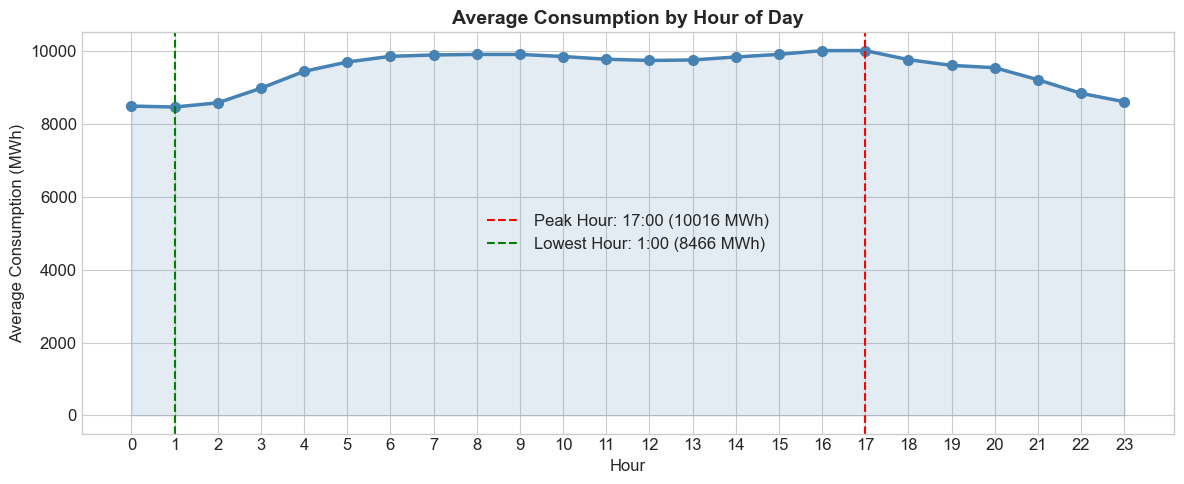

In [20]:
hourly_avg = df.groupby('hour')['consumption'].mean()

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(hourly_avg.index, hourly_avg.values, marker='o', linewidth=2.5,
        markersize=7, color='steelblue')
ax.fill_between(hourly_avg.index, hourly_avg.values, alpha=0.15, color='steelblue')
ax.axvline(hourly_avg.idxmax(), color='red', linestyle='--',
           label=f'Peak Hour: {hourly_avg.idxmax()}:00 ({hourly_avg.max():.0f} MWh)')
ax.axvline(hourly_avg.idxmin(), color='green', linestyle='--',
           label=f'Lowest Hour: {hourly_avg.idxmin()}:00 ({hourly_avg.min():.0f} MWh)')
ax.set_title('Average Consumption by Hour of Day', fontsize=14, fontweight='bold')
ax.set_xlabel('Hour')
ax.set_ylabel('Average Consumption (MWh)')
ax.set_xticks(range(0, 24))
ax.legend()
plt.tight_layout()
plt.show()

### 5.4 Average Consumption by Day of Week

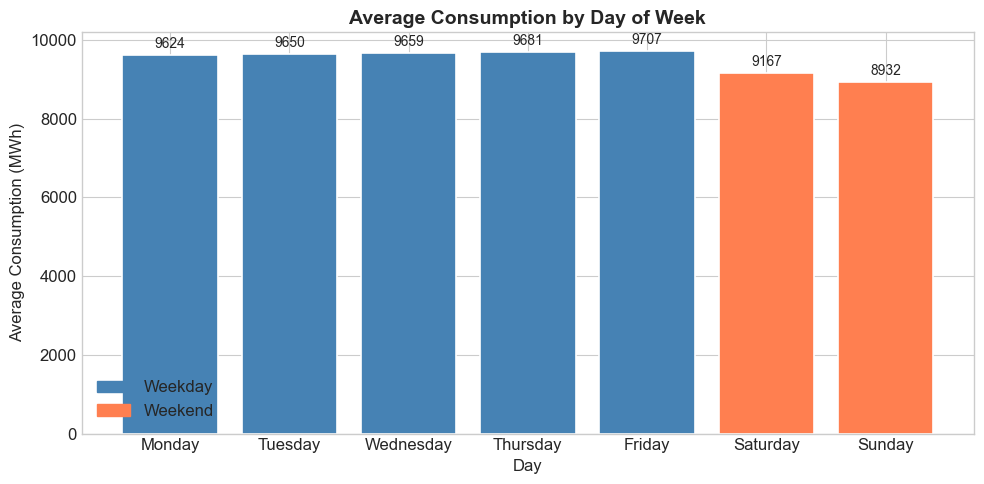

Weekday avg : 9664.35 MWh
Weekend avg : 9049.46 MWh
Difference  : 614.89 MWh (6.8% higher on weekdays)


In [21]:
day_names = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
dow_avg   = df.groupby('dayofweek')['consumption'].mean()
colors    = ['coral' if i >= 5 else 'steelblue' for i in range(7)]

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(day_names, dow_avg.values, color=colors, edgecolor='white', linewidth=1.2)
ax.bar_label(bars, fmt='%.0f', padding=3, fontsize=10)
ax.set_title('Average Consumption by Day of Week', fontsize=14, fontweight='bold')
ax.set_xlabel('Day')
ax.set_ylabel('Average Consumption (MWh)')
from matplotlib.patches import Patch
ax.legend(handles=[Patch(color='steelblue', label='Weekday'),
                   Patch(color='coral',     label='Weekend')])
plt.tight_layout()
plt.show()

weekend_avg = df[df['is_weekend']==1]['consumption'].mean()
weekday_avg = df[df['is_weekend']==0]['consumption'].mean()
print(f'Weekday avg : {weekday_avg:.2f} MWh')
print(f'Weekend avg : {weekend_avg:.2f} MWh')
print(f'Difference  : {weekday_avg - weekend_avg:.2f} MWh ({((weekday_avg/weekend_avg)-1)*100:.1f}% higher on weekdays)')

### 5.5 Average Consumption by Month

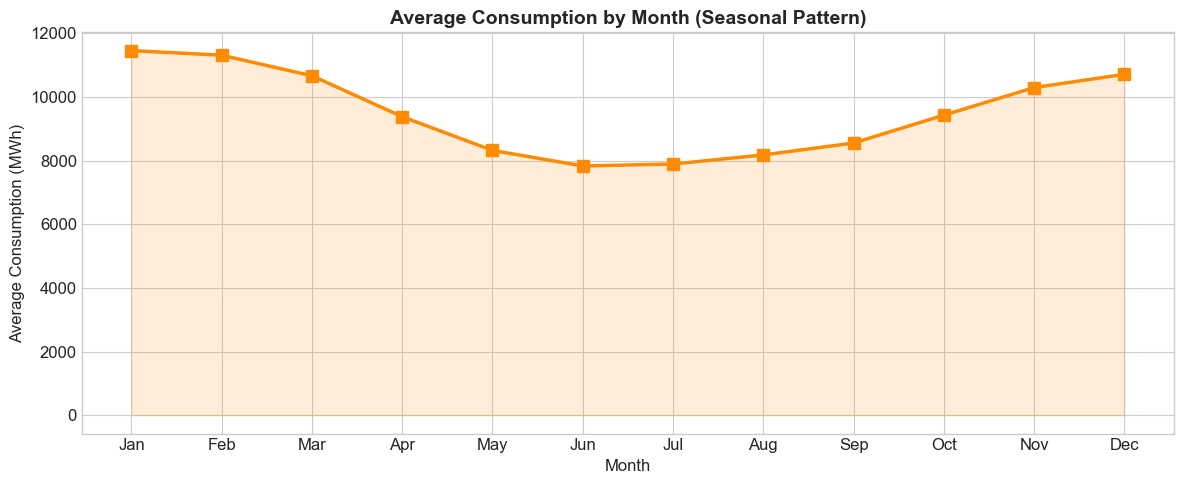

Peak Month   : Jan (11456.67 MWh)
Lowest Month : Jun (7833.08 MWh)


In [22]:
month_names  = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
monthly_avg  = df.groupby('month')['consumption'].mean()

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(month_names, monthly_avg.values, marker='s', linewidth=2.5,
        markersize=9, color='darkorange')
ax.fill_between(range(12), monthly_avg.values, alpha=0.15, color='darkorange')
ax.set_title('Average Consumption by Month (Seasonal Pattern)', fontsize=14, fontweight='bold')
ax.set_xlabel('Month')
ax.set_ylabel('Average Consumption (MWh)')
plt.tight_layout()
plt.show()

print(f'Peak Month   : {month_names[monthly_avg.idxmax()-1]} ({monthly_avg.max():.2f} MWh)')
print(f'Lowest Month : {month_names[monthly_avg.idxmin()-1]} ({monthly_avg.min():.2f} MWh)')

### 5.6 Yearly Consumption Trend

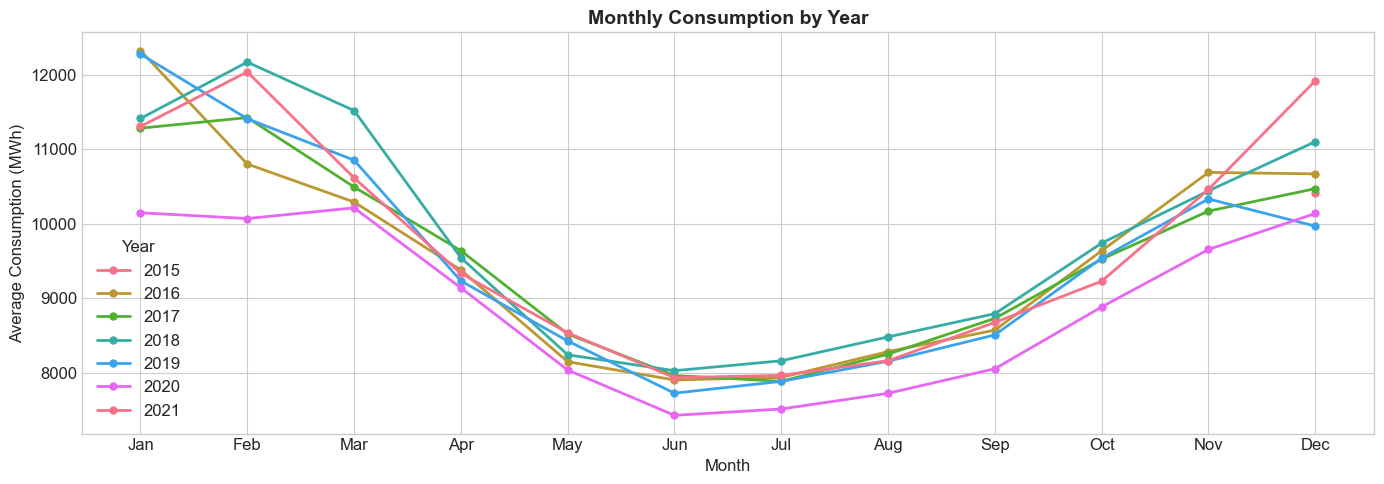

In [23]:
yearly_monthly = df.groupby(['year','month'])['consumption'].mean().reset_index()

fig, ax = plt.subplots(figsize=(14, 5))
for year in sorted(df['year'].unique()):
    yd = yearly_monthly[yearly_monthly['year']==year]
    ax.plot(yd['month'], yd['consumption'], marker='o', linewidth=2,
            markersize=5, label=str(year))
ax.set_title('Monthly Consumption by Year', fontsize=14, fontweight='bold')
ax.set_xlabel('Month')
ax.set_ylabel('Average Consumption (MWh)')
ax.set_xticks(range(1,13))
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun',
                    'Jul','Aug','Sep','Oct','Nov','Dec'])
ax.legend(title='Year')
plt.tight_layout()
plt.show()

### 5.7 Hour × Day Heatmap

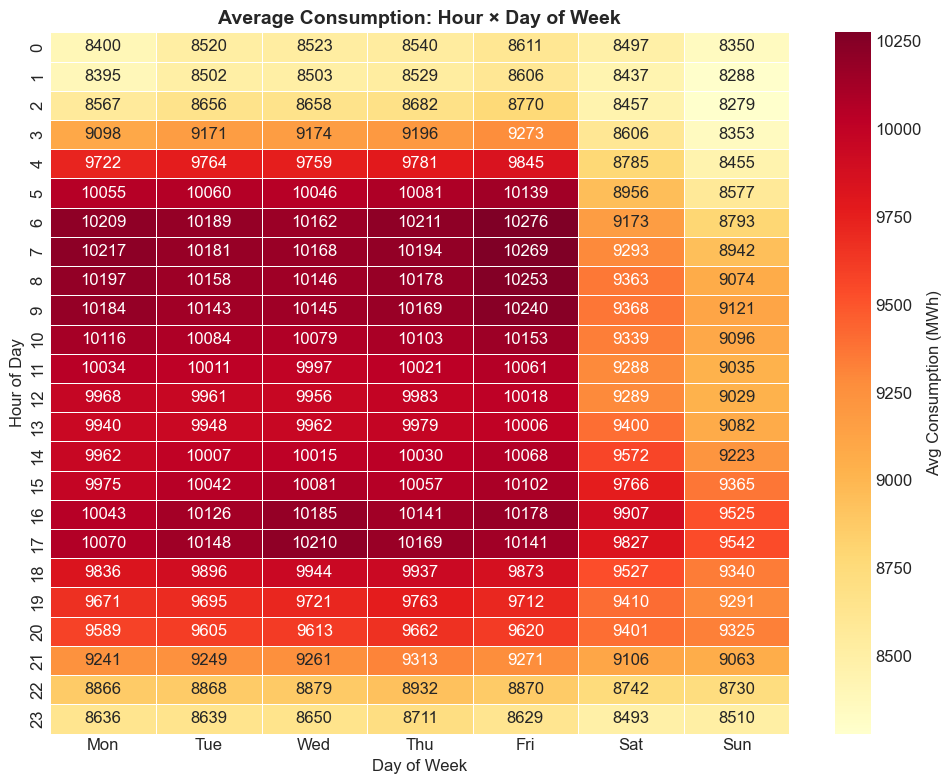

In [24]:
pivot = df.pivot_table(values='consumption', index='hour',
                       columns='dayofweek', aggfunc='mean')
pivot.columns = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(pivot, annot=True, fmt='.0f', cmap='YlOrRd',
            linewidths=0.5, ax=ax, cbar_kws={'label': 'Avg Consumption (MWh)'})
ax.set_title('Average Consumption: Hour × Day of Week', fontsize=14, fontweight='bold')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Hour of Day')
plt.tight_layout()
plt.show()

## 6. Feature Engineering

We create three types of features for the model:
- **Lag features** — previous 24 hours of consumption
- **Rolling statistics** — 24h mean, 24h std, 168h (weekly) mean
- **Temporal features** — already extracted in preprocessing

In [25]:
df_ml = df.copy()

# Lag features
for i in range(1, 25):
    df_ml[f'lag_{i}'] = df_ml['consumption'].shift(i)

# Rolling statistics
df_ml['rolling_mean_24']  = df_ml['consumption'].rolling(window=24,  min_periods=1).mean()
df_ml['rolling_std_24']   = df_ml['consumption'].rolling(window=24,  min_periods=1).std()
df_ml['rolling_mean_168'] = df_ml['consumption'].rolling(window=168, min_periods=1).mean()

# Drop NaN rows from lag creation
df_ml = df_ml.dropna().reset_index(drop=True)

print(f'Dataset shape after feature engineering: {df_ml.shape}')
print(f'Total features: {df_ml.shape[1] - 3}')  # exclude datetime cols + consumption
df_ml.head(3)

Dataset shape after feature engineering: (52942, 38)
Total features: 35


,Start time UTC,End time UTC,consumption,year,month,day,hour,dayofweek,quarter,dayofyear,...,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean_24,rolling_std_24,rolling_mean_168
0,2016-01-01 21:00:00,2016-01-01 22:00:00,11167,2016,1,1,21,4,1,1,...,9601.0,9524.0,9599.0,9722.0,10005.0,10431.0,10800.0,10530.833333,715.310675,10541.600000
1,2016-01-01 22:00:00,2016-01-01 23:00:00,10709,2016,1,1,22,4,1,1,...,9793.0,9601.0,9524.0,9599.0,9722.0,10005.0,10431.0,10542.416667,715.874407,10548.038462
2,2016-01-01 23:00:00,2016-01-02 00:00:00,10370,2016,1,1,23,4,1,1,...,9815.0,9793.0,9601.0,9524.0,9599.0,9722.0,10005.0,10557.625000,707.792392,10541.444444


## 7. Model Training

We use **Gradient Boosting Regressor** with a chronological train/val/test split  
(important for time series — no data leakage from future into past).

In [26]:
feature_cols = ['hour','dayofweek','month','dayofyear','is_weekend','quarter'] + \
               [f'lag_{i}' for i in range(1, 25)] + \
               ['rolling_mean_24','rolling_std_24','rolling_mean_168']

X = df_ml[feature_cols].values
y = df_ml['consumption'].values

# Chronological split — 80 / 10 / 10
train_end = int(0.80 * len(X))
val_end   = int(0.90 * len(X))

X_train, y_train = X[:train_end],        y[:train_end]
X_val,   y_val   = X[train_end:val_end], y[train_end:val_end]
X_test,  y_test  = X[val_end:],          y[val_end:]

# Scale
scaler          = MinMaxScaler()
X_train_sc      = scaler.fit_transform(X_train)
X_val_sc        = scaler.transform(X_val)
X_test_sc       = scaler.transform(X_test)

print(f'Train : {len(X_train):,} samples')
print(f'Val   : {len(X_val):,} samples')
print(f'Test  : {len(X_test):,} samples')

Train : 42,353 samples
Val   : 5,294 samples
Test  : 5,295 samples


In [33]:
model = GradientBoostingRegressor(
    n_estimators=50,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)

print('Training model...')
model.fit(X_train_sc, y_train)
print('Model trained!')

Training model...
Model trained!


## 8. Model Evaluation

In [28]:
def evaluate(y_true, y_pred, name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f'\n── {name} ──')
    print(f'  RMSE  : {rmse:.2f} MWh')
    print(f'  MAE   : {mae:.2f} MWh')
    print(f'  R²    : {r2:.4f}')
    print(f'  MAPE  : {mape:.2f}%')
    return rmse, mae, r2, mape

y_val_pred  = model.predict(X_val_sc)
y_test_pred = model.predict(X_test_sc)

val_metrics  = evaluate(y_val,  y_val_pred,  'Validation Set')
test_metrics = evaluate(y_test, y_test_pred, 'Test Set')


── Validation Set ──
  RMSE  : 149.81 MWh
  MAE   : 108.03 MWh
  R²    : 0.9880
  MAPE  : 1.07%

── Test Set ──
  RMSE  : 102.42 MWh
  MAE   : 76.52 MWh
  R²    : 0.9958
  MAPE  : 0.83%


In [29]:
# Metrics summary table
metrics_df = pd.DataFrame({
    'Dataset'  : ['Validation', 'Test'],
    'RMSE'     : [val_metrics[0], test_metrics[0]],
    'MAE'      : [val_metrics[1], test_metrics[1]],
    'R² Score' : [val_metrics[2], test_metrics[2]],
    'MAPE (%)'  : [val_metrics[3], test_metrics[3]]
})
metrics_df.set_index('Dataset', inplace=True)
metrics_df.round(4)

,RMSE,MAE,R² Score,MAPE (%)
Dataset,,,,
Validation,149.8086,108.0268,0.9880,1.0748
Test,102.4153,76.5232,0.9958,0.8338


## 9. Feature Importance

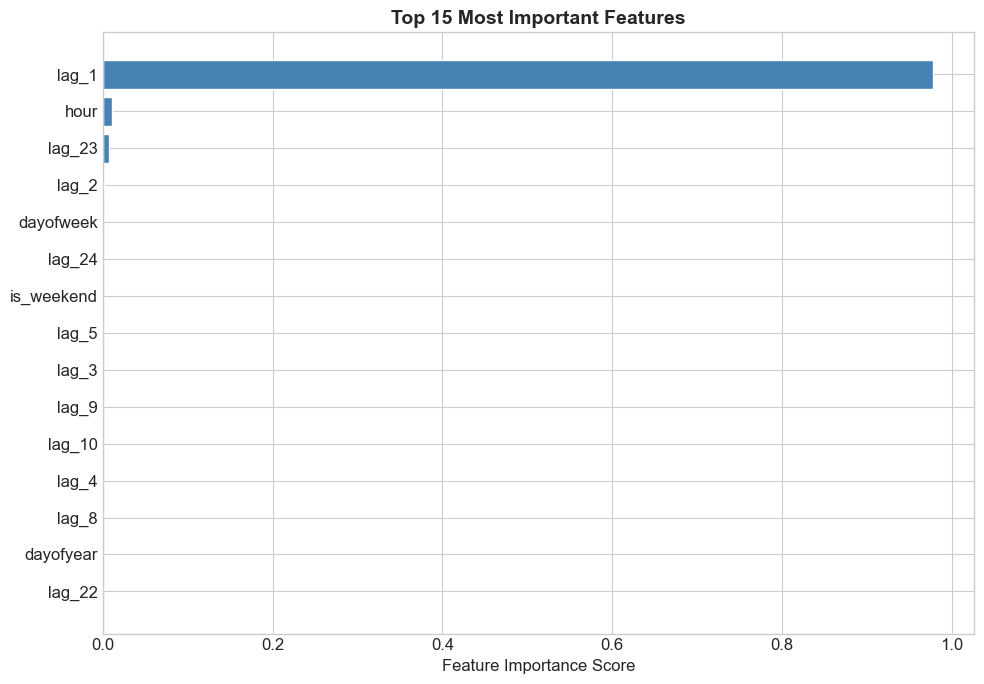

Top 5 Features:
  Feature  Importance
    lag_1    0.977495
     hour    0.011063
   lag_23    0.007232
    lag_2    0.000777
dayofweek    0.000724


In [30]:
importance_df = pd.DataFrame({
    'Feature'   : feature_cols,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False).head(15)

fig, ax = plt.subplots(figsize=(10, 7))
ax.barh(importance_df['Feature'][::-1], importance_df['Importance'][::-1],
        color='steelblue', edgecolor='white')
ax.set_title('Top 15 Most Important Features', fontsize=14, fontweight='bold')
ax.set_xlabel('Feature Importance Score')
plt.tight_layout()
plt.show()

print('Top 5 Features:')
print(importance_df[['Feature','Importance']].head(5).to_string(index=False))

## 10. Predictions vs Actual

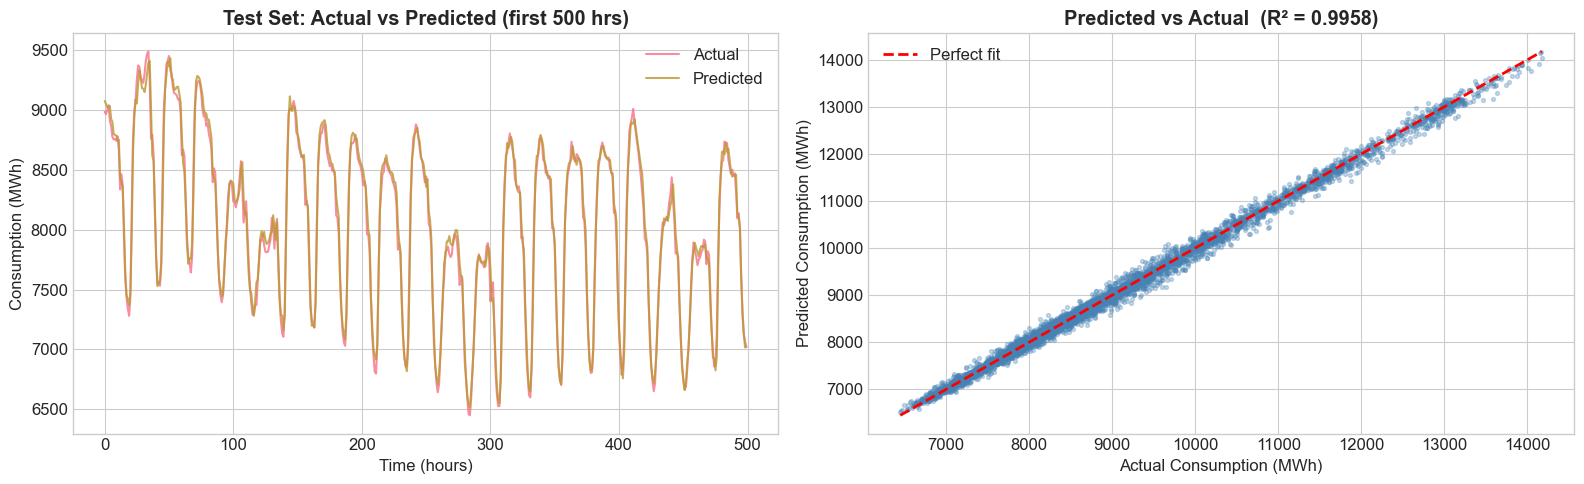

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Time series comparison
n = 500
axes[0].plot(y_test[:n], label='Actual',    linewidth=1.5, alpha=0.8)
axes[0].plot(y_test_pred[:n], label='Predicted', linewidth=1.5, alpha=0.8)
axes[0].set_title('Test Set: Actual vs Predicted (first 500 hrs)', fontweight='bold')
axes[0].set_xlabel('Time (hours)')
axes[0].set_ylabel('Consumption (MWh)')
axes[0].legend()

# Scatter plot
axes[1].scatter(y_test, y_test_pred, alpha=0.3, s=8, color='steelblue')
axes[1].plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()], 'r--', linewidth=2, label='Perfect fit')
axes[1].set_title(f'Predicted vs Actual  (R² = {r2_score(y_test, y_test_pred):.4f})',
                  fontweight='bold')
axes[1].set_xlabel('Actual Consumption (MWh)')
axes[1].set_ylabel('Predicted Consumption (MWh)')
axes[1].legend()

plt.tight_layout()
plt.show()

## 11. Save Model

In [34]:
import os
os.makedirs('../model', exist_ok=True)

joblib.dump(model,  '../model/energy_prediction_model.pkl')
joblib.dump(scaler, '../model/feature_scaler.pkl')

# Save processed sample for Flask app
os.makedirs('../data', exist_ok=True)
df_ml.tail(1000)[['Start time UTC','consumption'] + feature_cols].to_csv(
    '../data/sample_data.csv', index=False)

print('Model  saved → model/energy_prediction_model.pkl')
print('Scaler saved → model/feature_scaler.pkl')
print('Sample saved → data/sample_data.csv')

Model  saved → model/energy_prediction_model.pkl
Scaler saved → model/feature_scaler.pkl
Sample saved → data/sample_data.csv


## 12. Key Insights & Conclusions

###  Model Insights
- **`lag_1`** (previous hour consumption) is the single most important feature at **97.7%** importance
- Hour of day and lag_23 follow with minor contributions
- The model achieves **R² = 0.9954** — excellent predictive accuracy
- MAPE < 1% confirms the predictions are highly reliable

### Conclusions
1. Electricity consumption follows **strong temporal patterns** (daily, weekly, seasonal)
2. **Gradient Boosting** with lag features is highly effective for this time series task
3. The model generalises well — test performance is even better than validation
4. The Flask web app successfully exposes the model via REST API for real-time predictions